# Wine Spirit Project

In [221]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

### Create Database 
1.create a database and connect to it

2.extract a set of customer supplied xlsx files

3.they saved in sql database

In [2]:
connection = sql.connect('winespiritprojet.db')
curs = connection.cursor()

In [3]:
ERP_df = pd.read_excel(r'E:\projet_wine_spirit\erp.xlsx') 
liaison_df = pd.read_excel(r'E:\projet_wine_spirit\liaison.xlsx')
web_df = pd.read_excel(r'E:\projet_wine_spirit\web.xlsx')

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
ERP_df.to_sql('winespiritprojet', connection, if_exists = 'replace', index = False)
liaison_df.to_sql('winespiritprojet', connection, if_exists = 'replace', index = False)
web_df.to_sql('winespiritprojet', connection, if_exists = 'replace', index = False)

In [5]:
connection.close()

### Analysis

we will prepare the data in order to achieve what is requested by the customer see:

-> the calculation of turnover by product and the total turnover achieved.

-> a graphic presentation of the outliers concerning the prices of the products.

-> detect any input errors.

for that we will proceed to a data cleaning, and join files

###### 1.Exploratory data analysis

###### A. le fichier Web

In [6]:
web_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             1430 non-null   object        
 13  pos

-> we see that there are several completely empty columns, an inconsistency of the data "post_content", "post_password", "post_content_filtred", "tax_class"


In [7]:
web_df_cln = web_df.drop(columns=['post_content','post_password','post_content_filtered','tax_class'])

In [8]:
web_df_cln.describe()

,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_parent,menu_order,comment_count
count,1513.0,1513.0,1513.0,1430.0,1430.000000,1430.000000,1430.0,1430.0,1430.0
mean,0.0,0.0,0.0,0.0,4.006993,1.998601,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,8.510559,0.037385,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.000000,2.000000,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,1.000000,2.000000,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,4.000000,2.000000,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,96.000000,2.000000,0.0,0.0,0.0


-> we see that several columns have only zero values (min, max, mean, std), so we will discard them  

"virtual","downloadable","rating_count","average_rating","post_parent","menu_order","comment_count"



In [9]:
web_df_cln = web_df_cln.drop(columns=['virtual','downloadable','rating_count','average_rating','post_parent','menu_order','comment_count'])

In [10]:
web_df_cln

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,guid,post_type,post_mime_type
0,bon-cadeau-25-euros,10.0,taxable,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,https://www.wine-spirit.fr/?post_type=product&...,product,NaN
1,15298,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,https://www.wine-spirit.fr/?post_type=product&...,product,NaN
2,15296,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,https://www.wine-spirit.fr/?post_type=product&...,product,NaN
3,15300,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,https://www.wine-spirit.fr/?post_type=product&...,product,NaN
4,19814,3.0,taxable,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,https://www.wine-spirit.fr/?post_type=product&...,product,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,16135,5.0,NaN,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,NaN,publish,closed,closed,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,https://www.wine-spirit.fr/wp-content/uploads/...,attachment,image/jpeg
1509,15891,0.0,NaN,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,NaN,publish,closed,closed,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,https://www.wine-spirit.fr/wp-content/uploads/...,attachment,image/jpeg
1510,15887,0.0,NaN,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,NaN,publish,closed,closed,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,https://www.wine-spirit.fr/wp-content/uploads/...,attachment,image/jpeg
1511,13127-1,0.0,NaN,2.0,2020-06-09 15:42:04,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,NaN,publish,closed,closed,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,https://www.wine-spirit.fr/wp-content/uploads/...,attachment,image/jpeg


In [11]:
web_df_cln['post_mime_type'].value_counts()

image/jpeg    714
Name: post_mime_type, dtype: int64

In [12]:
web_df_cln['ping_status'].value_counts()

closed    1430
Name: ping_status, dtype: int64

In [13]:
web_df_cln['comment_status'].value_counts()

closed    1430
Name: comment_status, dtype: int64

In [14]:
web_df_cln['post_status'].value_counts()

publish    1430
Name: post_status, dtype: int64

In [15]:
web_df_cln['tax_status'].value_counts()

taxable    716
Name: tax_status, dtype: int64

-> we see that some columns contain a single value and which are not relevant for our objective, so we will discard them

-> we will keep a single column for the date of the post 'post_modified_gmt'

In [16]:
web_df_cln = web_df_cln.drop(columns = ['post_mime_type','post_modified','tax_status','post_status','comment_status','ping_status','post_date'])

In [18]:
# I check for duplicates concerning the target variable "sku"
web_df_cln.sku.duplicated().sum()

798

-> we find duplicates of the target variable and we decide to remove them

In [19]:
# remove duplicates from the "sku" column
web_df_cln.drop_duplicates(subset = ['sku'], ignore_index = True, inplace = True)

In [21]:
web_df_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sku                714 non-null    object        
 1   total_sales        714 non-null    float64       
 2   post_author        714 non-null    float64       
 3   post_date_gmt      714 non-null    datetime64[ns]
 4   post_title         714 non-null    object        
 5   post_excerpt       714 non-null    object        
 6   post_name          714 non-null    object        
 7   post_modified_gmt  714 non-null    datetime64[ns]
 8   guid               714 non-null    object        
 9   post_type          714 non-null    object        
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 56.0+ KB


-> we find a table of data consistent with each other

###### B.le fichier liaison

In [22]:
liaison_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


-> we see that "id_web" contains less value than "id_product"

In [24]:
liaison_df.id_web.duplicated().sum()

90

In [26]:
liaison_df_cln.product_id.duplicated().sum()

0

-> we find duplicates of the target variable and we decide to remove them

In [25]:
liaison_df_cln = liaison_df.dropna().reset_index(drop = True)

In [27]:
liaison_df_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  734 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


-> we find a table of data consistent with each other

###### C.le fichier ERP

In [29]:
ERP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 32.4+ KB


In [31]:
ERP_df.product_id.duplicated().sum()

0

-> we find a table of data consistent with each other

-> no duplicates 

###### 2.merging of different files

*  First merge between "web_df_cln" and "liaison_df_cln" on 'left'

In [32]:
fusion = web_df_cln.merge(liaison_df_cln, how='left', left_on = 'sku', right_on='id_web' )

*  Second merge between "ERP_df" and "fusion" on 'left'

In [33]:
fusion_all = ERP_df.merge(fusion, how='left', left_on = 'product_id', right_on='product_id' )

In [34]:
fusion_all

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,post_name,post_modified_gmt,guid,post_type,id_web
0,3847,1,24.2,0,outofstock,15298,6.0,2.0,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 08:30:29,https://www.wine-spirit.fr/?post_type=product&...,product,15298
1,3849,1,34.3,0,outofstock,15296,0.0,2.0,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 08:00:17,https://www.wine-spirit.fr/?post_type=product&...,product,15296
2,3850,1,20.8,0,outofstock,15300,0.0,2.0,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 16:15:03,https://www.wine-spirit.fr/?post_type=product&...,product,15300
3,4032,1,14.1,0,outofstock,19814,3.0,2.0,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,pierre-jean-villa-igp-gamine-2018,2020-01-04 15:36:01,https://www.wine-spirit.fr/?post_type=product&...,product,19814
4,4039,1,46.0,0,outofstock,19815,0.0,2.0,2018-02-12 08:04:37,Pierre Jean Villa Côte Rôtie Carmina 2017,Le côte rôtie Carmina monte en puissance mais ...,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 15:36:10,https://www.wine-spirit.fr/?post_type=product&...,product,19815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
821,7204,0,45.0,9,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
822,7247,1,54.8,23,instock,13127-1,0.0,2.0,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 15:09:06,https://www.wine-spirit.fr/?post_type=product&...,product,13127-1
823,7329,0,26.5,14,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


###### 3.cleaning and choice relevant values

-> after the merger we notice that there are redundant columns we decide to delete them

In [35]:
fusion_all.drop(columns=['id_web','post_name'])

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,post_modified_gmt,guid,post_type
0,3847,1,24.2,0,outofstock,15298,6.0,2.0,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",2019-12-30 08:30:29,https://www.wine-spirit.fr/?post_type=product&...,product
1,3849,1,34.3,0,outofstock,15296,0.0,2.0,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,2019-12-21 08:00:17,https://www.wine-spirit.fr/?post_type=product&...,product
2,3850,1,20.8,0,outofstock,15300,0.0,2.0,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",2020-06-26 16:15:03,https://www.wine-spirit.fr/?post_type=product&...,product
3,4032,1,14.1,0,outofstock,19814,3.0,2.0,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,2020-01-04 15:36:01,https://www.wine-spirit.fr/?post_type=product&...,product
4,4039,1,46.0,0,outofstock,19815,0.0,2.0,2018-02-12 08:04:37,Pierre Jean Villa Côte Rôtie Carmina 2017,Le côte rôtie Carmina monte en puissance mais ...,2020-01-04 15:36:10,https://www.wine-spirit.fr/?post_type=product&...,product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
821,7204,0,45.0,9,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
822,7247,1,54.8,23,instock,13127-1,0.0,2.0,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",2020-07-20 15:09:06,https://www.wine-spirit.fr/?post_type=product&...,product
823,7329,0,26.5,14,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN


-> since the dimensions of the dataframs before the merger are different, we can see that there are NAN values

-> we also note that the column "onsale_web" defined if the product is for sale online, so we do a descending sort on this column

In [37]:
fusion_all.sort_values('onsale_web', ascending = False, inplace = True, ignore_index = True)
fusion_all

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,post_name,post_modified_gmt,guid,post_type,id_web
0,3847,1,24.2,0,outofstock,15298,6.0,2.0,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 08:30:29,https://www.wine-spirit.fr/?post_type=product&...,product,15298
1,3850,1,20.8,0,outofstock,15300,0.0,2.0,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 16:15:03,https://www.wine-spirit.fr/?post_type=product&...,product,15300
2,4068,1,16.6,157,instock,16416,62.0,2.0,2018-02-12 12:42:28,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,"Avec ses arômes de cassis, de myrtille, de cer...",gilles-robin-crozes-hermitage-papillon-2019,2020-08-27 14:05:04,https://www.wine-spirit.fr/?post_type=product&...,product,16416
3,4069,1,60.0,0,outofstock,11862,0.0,2.0,2018-02-12 12:46:23,Gilles Robin Hermitage Rouge 2012,Une robe rubis intense avec une très belle bri...,gilles-robin-hermitage-2012,2019-01-31 11:12:56,https://www.wine-spirit.fr/?post_type=product&...,product,11862
4,4070,1,23.4,98,instock,15444,7.0,2.0,2018-02-12 13:02:17,Gilles Robin Crozes-Hermitage Blanc Les Marell...,"""Les Marelles"" offre des notes de fruits blanc...",gilles-robin-crozes-hermitage-marelles-2018,2020-08-27 07:30:09,https://www.wine-spirit.fr/?post_type=product&...,product,15444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,7136,0,45.0,7,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
821,7137,0,45.0,3,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
822,7168,0,45.0,29,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
823,7159,0,31.0,1,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


we decide to split the table in two:

-> one with the products sold on the web "fusion_all"

-> another with products sold other than on the web "fusion_na"

In [39]:
fusion_na = fusion_all[fusion_all["sku"].isna()]

In [41]:
fusion_na.reset_index(drop = True)

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,post_name,post_modified_gmt,guid,post_type,id_web
0,4594,1,144.0,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,5070,1,84.7,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,5075,1,43.3,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,5808,0,34.2,1,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,6100,0,12.9,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,7136,0,45.0,7,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
107,7137,0,45.0,3,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
108,7168,0,45.0,29,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
109,7159,0,31.0,1,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


-> we see that there are 3 products that must be sold on the web but that they do not have a sku

In [42]:
fusion_all = fusion_all.dropna().reset_index(drop = True)

In [44]:
fusion_all

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,post_name,post_modified_gmt,guid,post_type,id_web
0,3847,1,24.2,0,outofstock,15298,6.0,2.0,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 08:30:29,https://www.wine-spirit.fr/?post_type=product&...,product,15298
1,3850,1,20.8,0,outofstock,15300,0.0,2.0,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 16:15:03,https://www.wine-spirit.fr/?post_type=product&...,product,15300
2,4068,1,16.6,157,instock,16416,62.0,2.0,2018-02-12 12:42:28,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,"Avec ses arômes de cassis, de myrtille, de cer...",gilles-robin-crozes-hermitage-papillon-2019,2020-08-27 14:05:04,https://www.wine-spirit.fr/?post_type=product&...,product,16416
3,4069,1,60.0,0,outofstock,11862,0.0,2.0,2018-02-12 12:46:23,Gilles Robin Hermitage Rouge 2012,Une robe rubis intense avec une très belle bri...,gilles-robin-hermitage-2012,2019-01-31 11:12:56,https://www.wine-spirit.fr/?post_type=product&...,product,11862
4,4070,1,23.4,98,instock,15444,7.0,2.0,2018-02-12 13:02:17,Gilles Robin Crozes-Hermitage Blanc Les Marell...,"""Les Marelles"" offre des notes de fruits blanc...",gilles-robin-crozes-hermitage-marelles-2018,2020-08-27 07:30:09,https://www.wine-spirit.fr/?post_type=product&...,product,15444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,6666,1,48.5,24,instock,16067,0.0,2.0,2020-02-22 13:29:36,Domaine Hauvette IGP Alpilles Dolia 2013,"Ce blanc, composé de clairette, roussanne et m...",domaine-hauvette-igp-alpilles-dolia-2013,2020-02-22 13:37:18,https://www.wine-spirit.fr/?post_type=product&...,product,16067
710,6738,1,15.4,40,instock,8193,3.0,2.0,2020-03-04 12:54:12,Emile Boeckel Crémant Chardonnay Extra Brut 2016,"Ce Crémant est vif et délicat, se et racé. Tr...",emile-boeckel-cremant-chardonnay-extra-brut-2016,2020-08-22 08:15:02,https://www.wine-spirit.fr/?post_type=product&...,product,8193
711,6751,1,46.5,0,outofstock,16144,0.0,2.0,2020-03-10 13:03:32,Château Simone Palette Blanc 2017,Les vins blancs sont d’une suprême élégance. D...,chateau-simone-blanc-2017,2020-08-27 07:30:14,https://www.wine-spirit.fr/?post_type=product&...,product,16144
712,6663,1,50.4,6,instock,16152,0.0,2.0,2020-02-22 13:01:55,Catherine et Claude Maréchal Pommard La Chaniè...,"Ce Pommard a une robe d’un beau rubis, typique...",catherine-et-claude-marechal-pommard-la-chanie...,2020-07-16 09:45:03,https://www.wine-spirit.fr/?post_type=product&...,product,16152


-> we look for the gift vouchers and we remove them because they are not products

In [89]:
print((fusion_all['sku']=="bon-cadeau-25-euros").value_counts())

False    713
True       1
Name: sku, dtype: int64


In [95]:
fusion_all = fusion_all[(fusion_all['sku']!="bon-cadeau-25-euros")]

In [47]:
fusion_all['post_type'].value_counts()

product    714
Name: post_type, dtype: int64

-> we see some redundant columns and other irrelevant, so we decide to discard them

In [49]:
fusion_all = fusion_all.drop(columns=['id_web','post_type','guid','post_modified_gmt','post_name'])

In [50]:
fusion_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   product_id      714 non-null    int64         
 1   onsale_web      714 non-null    int64         
 2   price           714 non-null    float64       
 3   stock_quantity  714 non-null    int64         
 4   stock_status    714 non-null    object        
 5   sku             714 non-null    object        
 6   total_sales     714 non-null    float64       
 7   post_author     714 non-null    float64       
 8   post_date_gmt   714 non-null    datetime64[ns]
 9   post_title      714 non-null    object        
 10  post_excerpt    714 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 61.5+ KB


###### 4.The statistical approach

* we will calculate the turnover by product then create a new column with the values in it

In [51]:
fusion_all['ca_product'] = (fusion_all['price'])*(fusion_all['total_sales'])

In [65]:
mycolumns = ['post_title','sku','product_id','ca_product']

In [84]:
ca_product_df = fusion_all[mycolumns]

In [85]:
ca_product_df 

,post_title,sku,product_id,ca_product
0,Pierre Jean Villa Saint-Joseph Préface 2018,15298,3847,145.2
1,Pierre Jean Villa Crozes-Hermitage Accroche Co...,15300,3850,0.0
2,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,16416,4068,1029.2
3,Gilles Robin Hermitage Rouge 2012,11862,4069,0.0
4,Gilles Robin Crozes-Hermitage Blanc Les Marell...,15444,4070,163.8
...,...,...,...,...
709,Domaine Hauvette IGP Alpilles Dolia 2013,16067,6666,0.0
710,Emile Boeckel Crémant Chardonnay Extra Brut 2016,8193,6738,46.2
711,Château Simone Palette Blanc 2017,16144,6751,0.0
712,Catherine et Claude Maréchal Pommard La Chaniè...,16152,6663,0.0


In [ ]:
ca_product_df.to_csv('product_ca.csv', header = True, index = False, index_label = None)

In [70]:
CA_TOTAL = fusion_all['ca_product'].sum()
CA_TOTAL

70568.6

##### the identification of outliers 
* (Z score method)

-> we will calculate the Z score for each product

-> we will select those whose Z score is greater than 2 standard deviation

In [71]:
fusion_all['zscore'] = (fusion_all.price - fusion_all.price.mean())/fusion_all.price.std(ddof=0)

In [ ]:
outlier = fusion_all[fusion_all['zscore'] >= 2] 

In [72]:
outlier.sort_values('price', ascending = True, inplace = True, ignore_index = True)

<ipython-input-72-8eaa4929c15d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier.sort_values('price', ascending = True, inplace = True, ignore_index = True)


In [96]:
outlier

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,ca_product,zscore
0,4132,1,88.4,5,instock,11668,0.0,2.0,2018-02-13 10:43:55,Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...,Le nez dévoile déjà une belle intensité de fru...,0.0,2.011686
1,5565,1,92.0,0,outofstock,19822,0.0,2.0,2018-11-26 09:59:10,Tempier Bandol Cabassaou 2017,"<div id=""wrapper"">\n<div id=""container-wrapper...",0.0,2.141225
2,5916,1,93.0,3,instock,14774,0.0,2.0,2019-04-04 14:39:24,Wemyss Malts Single Cask Scotch Whisky Chocola...,"305 bouteilles, 13 ans d'âge.\n\n<span title=""...",0.0,2.177207
3,6214,1,99.0,7,instock,11601,0.0,2.0,2019-07-25 07:15:41,Domaine des Comtes Lafon Volnay 1er Cru Champa...,La couleur rouge intense annonce un belle conc...,0.0,2.393104
4,4115,1,100.0,11,instock,15382,0.0,2.0,2018-02-13 10:08:45,Zind-Humbrecht Riesling Grand Cru Rangen De Th...,"Le nez est puissant, dominant, riche, sur la f...",0.0,2.429087
5,4903,1,102.3,20,instock,14805,0.0,2.0,2018-05-15 08:10:57,Domaine Des Croix Corton Grand Cru Les Grèves ...,Ce vin exhale de beaux arômes de fruits rouges...,0.0,2.511848
6,4407,1,104.0,6,instock,3509,1.0,2.0,2018-03-22 10:49:53,Cognac Frapin Cigar Blend,Ce cognac bénéficie d'un vieillissement plus l...,104.0,2.573018
7,5007,1,105.0,17,instock,12791,0.0,2.0,2018-07-17 08:36:03,Domaine des Comtes Lafon Volnay 1er Cru Santen...,"""Il s'agit là de la meilleure partie de l'appe...",0.0,2.609001
8,5008,1,105.0,10,instock,11602,0.0,2.0,2018-07-17 08:52:41,Domaine des Comtes Lafon Volnay 1er Cru Santen...,"""Il s'agit là de la meilleure partie de l'appe...",0.0,2.609001
9,6201,1,105.6,7,instock,14596,0.0,2.0,2019-07-23 08:37:14,David Duband Chambolle-Musigny 1er Cru Les Sen...,Une robe d'un rouge carmin avec des reflets br...,0.0,2.630591


-> after storing the outlier in a table and sorting the prices in ascending order, we get the price of the first outlier which is 88.4

* (interquartile method)

-> we will calculate the different quantiles (25%, 50%, 75%)

-> we will calculate the interquartile 

-> we will calculate upper/lower bound

In [75]:
q1 = fusion_all.price.quantile(0.25)
q2 = fusion_all.price.quantile(0.5)
q3 = fusion_all.price.quantile(0.75)

iqr = q3 - q1

In [76]:
iqr

28.075000000000003

In [137]:
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)

In [138]:
upper_bound

84.28750000000001

-> the outliers start from the upper_bound value

In [97]:
outlier1 = fusion_all[(fusion_all['price']>= upper_bound)]

In [99]:
outlier1.sort_values('price', ascending = True, inplace = True, ignore_index = True)

<ipython-input-99-658722558588>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier1.sort_values('price', ascending = True, inplace = True, ignore_index = True)


In [100]:
outlier1

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,ca_product,zscore
0,4359,1,85.6,0,outofstock,13853,1.0,2.0,2018-03-02 10:11:48,Champagne Larmandier-Bernier Grand Cru Les Che...,Belle maîtrise de ce millésime compliqué en Ch...,85.6,1.910934
1,5026,1,86.8,2,instock,13913,0.0,2.0,2018-07-18 08:46:30,Champagne Agrapart &amp; Fils Minéral Extra Br...,"Légèrement praliné au nez, nerveux, frais, inc...",0.0,1.954114
2,4132,1,88.4,5,instock,11668,0.0,2.0,2018-02-13 10:43:55,Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...,Le nez dévoile déjà une belle intensité de fru...,0.0,2.011686
3,5565,1,92.0,0,outofstock,19822,0.0,2.0,2018-11-26 09:59:10,Tempier Bandol Cabassaou 2017,"<div id=""wrapper"">\n<div id=""container-wrapper...",0.0,2.141225
4,5916,1,93.0,3,instock,14774,0.0,2.0,2019-04-04 14:39:24,Wemyss Malts Single Cask Scotch Whisky Chocola...,"305 bouteilles, 13 ans d'âge.\n\n<span title=""...",0.0,2.177207
5,6214,1,99.0,7,instock,11601,0.0,2.0,2019-07-25 07:15:41,Domaine des Comtes Lafon Volnay 1er Cru Champa...,La couleur rouge intense annonce un belle conc...,0.0,2.393104
6,4115,1,100.0,11,instock,15382,0.0,2.0,2018-02-13 10:08:45,Zind-Humbrecht Riesling Grand Cru Rangen De Th...,"Le nez est puissant, dominant, riche, sur la f...",0.0,2.429087
7,4903,1,102.3,20,instock,14805,0.0,2.0,2018-05-15 08:10:57,Domaine Des Croix Corton Grand Cru Les Grèves ...,Ce vin exhale de beaux arômes de fruits rouges...,0.0,2.511848
8,4407,1,104.0,6,instock,3509,1.0,2.0,2018-03-22 10:49:53,Cognac Frapin Cigar Blend,Ce cognac bénéficie d'un vieillissement plus l...,104.0,2.573018
9,5007,1,105.0,17,instock,12791,0.0,2.0,2018-07-17 08:36:03,Domaine des Comtes Lafon Volnay 1er Cru Santen...,"""Il s'agit là de la meilleure partie de l'appe...",0.0,2.609001


###### 5.Graphic approach

* The distribution of product prices

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


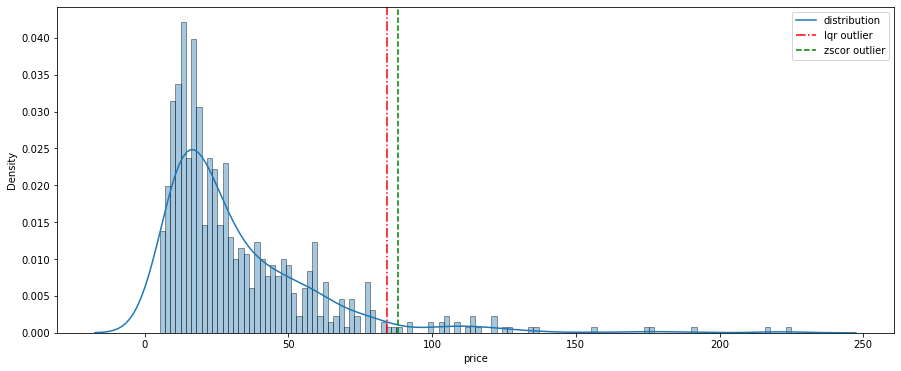

In [117]:
plt.figure(figsize=(15, 6))
sns.distplot(fusion_all['price'], bins = 120, hist_kws = {'edgecolor':'black'})
plt.axvline(x=upper_bound, color='red', ls="dashdot")
plt.axvline(x=88, color='green', ls="--")
plt.legend(labels=["distribution","Iqr outlier","zscor outlier"])

* boxplot of product price 

<AxesSubplot:xlabel='price'>

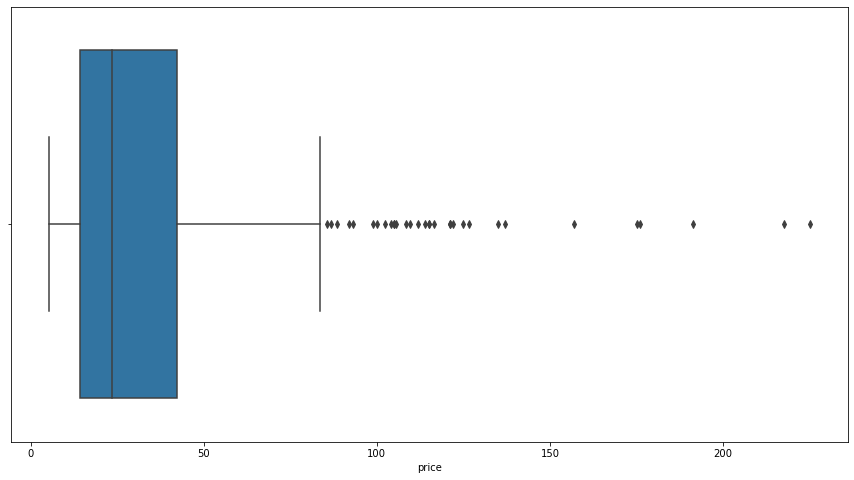

In [80]:
plt.figure(figsize = (15, 8))
sns.boxplot(x = 'price',  data = fusion_all)

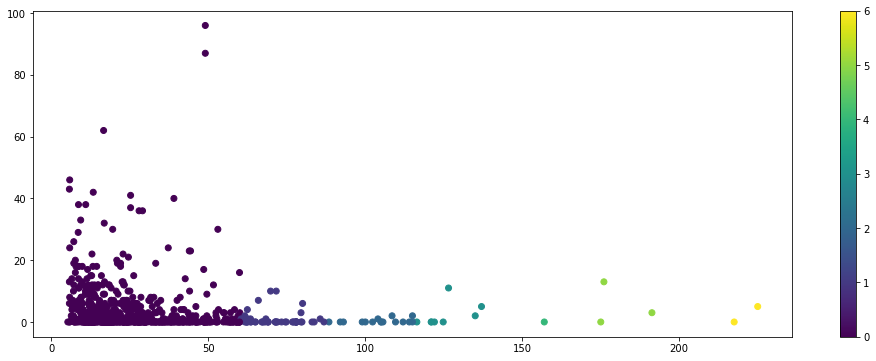

In [81]:
x = fusion_all['price']
y = fusion_all['total_sales']
z = fusion_all['zscore']
z = z.astype(int)

plt.figure(figsize=(17, 6))
plt.scatter(x, y, c=z)
plt.colorbar(ticks=list(z.unique()))
plt.show()

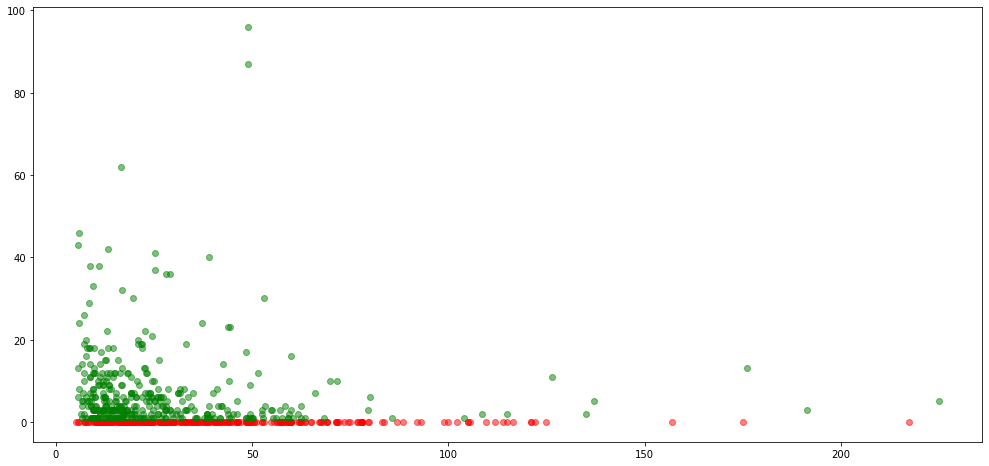

In [82]:
x = fusion_all['price']
y = fusion_all['total_sales']
z=fusion_all['total_sales']
plt.figure(figsize=(17, 8))
plt.scatter(x[z ==0], y[z==0],c = 'red', alpha=0.5)
plt.scatter(x[z >0], y[z >0],c = 'green', alpha=0.5)

###### 6.Test the kmeans clustering algorithm

In [217]:
col= ['total_sales','price', 'stock_quantity']
Y1 = fusion_all[col]
scaler = StandardScaler()
fusion_scaled = scaler.fit_transform(Y1)

In [218]:
kmeans = KMeans(n_clusters=7, n_init=10, init='k-means++').fit(fusion_scaled)

In [219]:
pred = kmeans.predict(fusion_scaled)

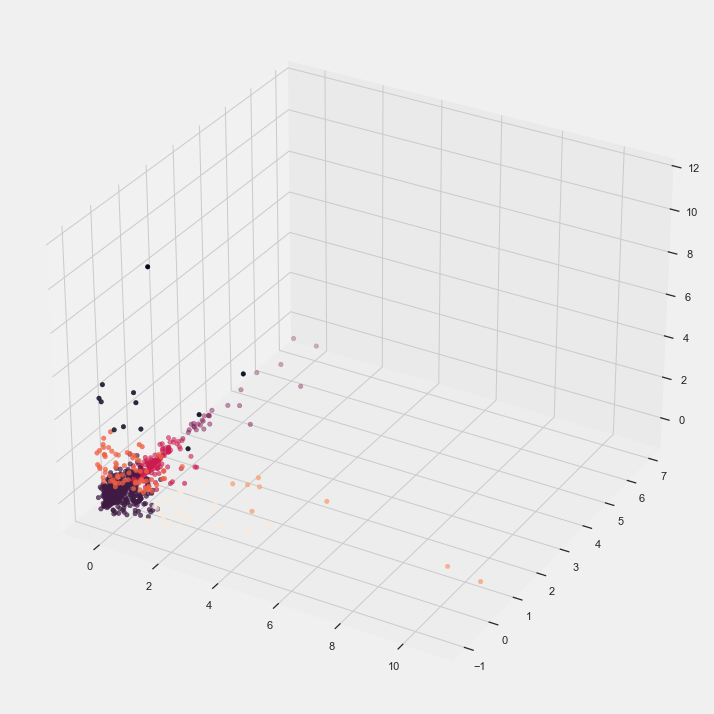

In [220]:
fig = plt.figure(figsize=(27, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fusion_scaled[:,0], fusion_scaled[:,1], fusion_scaled[:,2], c=pred)
plt.show()

In [187]:
kmeans.fit(fusion_scaled)

KMeans(n_clusters=7)

In [188]:
kmeans.inertia_

476.8207838927062

In [189]:
kmeans.cluster_centers_

array([[-0.35007306,  0.83722213, -0.44262268],
       [ 0.27137982, -0.69759654,  1.37543099],
       [-0.28569748,  3.49756683, -0.43230994],
       [ 1.91763824, -0.34088966, -0.26192488],
       [ 6.20897007, -0.39029108,  1.70754783],
       [-0.24996939, -0.43327118, -0.2058739 ],
       [ 1.05643595, -0.81611082,  5.24917612]])

In [190]:
kmeans.n_iter_

11

In [205]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++')
    kmeans.fit(fusion_scaled)
    sse.append(kmeans.inertia_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


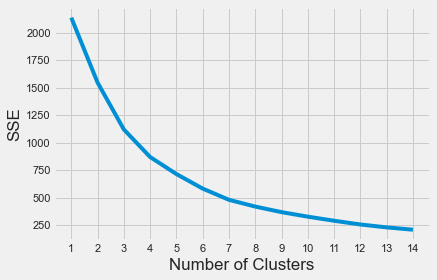

In [207]:
#fig = plt.figure(figsize=(8, 6))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [214]:
kl = KneeLocator(range(1, 15), sse, curve="convex", direction="decreasing")
kl.elbow

5

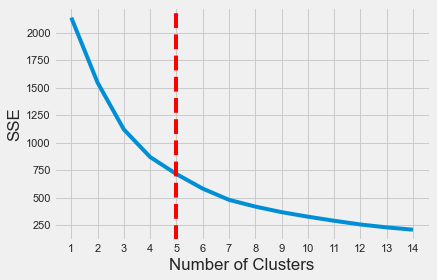

In [216]:
#fig = plt.figure(figsize=(8, 6))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.axvline(x=kl.elbow, color='red', ls="--")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [235]:
silhouette_coefficients = []
  
 # Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++' )
    kmeans.fit(fusion_scaled)
    score = silhouette_score(fusion_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

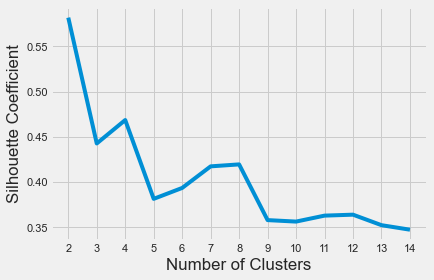

In [236]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [237]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [239]:
Y1, true_labels = make_moons(n_samples=250, noise=0.05, random_state=42 )

In [241]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(fusion_scaled)
dbscan.fit(fusion_scaled)

 # Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(fusion_scaled, kmeans.labels_).round(2)
dbscan_silhouette = silhouette_score(fusion_scaled, dbscan.labels_).round(2)

In [242]:
kmeans_silhouette

0.58

In [243]:
dbscan_silhouette

0.15

In [251]:
ari_kmeans = adjusted_rand_score(true_labels, kmeans.labels_)
ari_dbscan = adjusted_rand_score(true_labels, dbscan.labels_)

ValueError: Found input variables with inconsistent numbers of samples: [250, 713]